In [2]:
import mglearn

citibike = mglearn.datasets.load_citibike()
print(f"Citi bike data:\n {citibike.head()}")

Citi bike data:
 starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


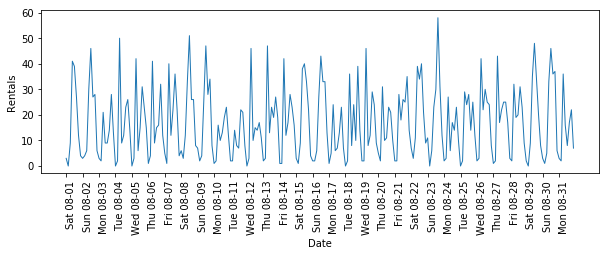

In [5]:
from matplotlib import pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 3))

xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq = 'D')
plt.xticks(xticks, xticks.strftime('%a %m-%d'), rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Rentals')
plt.show()

In [23]:
# 過去から学習し、未来を予測するアプローチを取る
import numpy as np

# ターゲット値（レンタル数）を抽出
y = citibike.values
# 時刻を '%s' でPOSIXに変換
X = np.array(citibike.index.astype('int64').tolist()).reshape(-1, 1)

# 最初の184点を訓練に、残りはテストに使用する
n_train = 184

# 与えられた特徴量セットで、回帰器を評価しプロットする関数
def eval_on_features(features, target, regressor):
    # 与えられた特徴量を訓練セットとテストセットに分割する
    X_train, X_test = features[:n_train], features[n_train:]
    # ターゲットの配列も分割する
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print(f"Test set R^2: {round(regressor.score(X_test, y_test), 3)}")
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime('%a %m-%d'), rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='train')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='test')
    plt.plot(range(n_train), y_pred_train, '--', label='predictioin train')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label='prediction test')
    plt.legend(loc=(1.01, 0))
    plt.xlabel('Date')
    plt.ylabel('Rentals')

Test set R^2: -0.035


<Figure size 432x288 with 0 Axes>

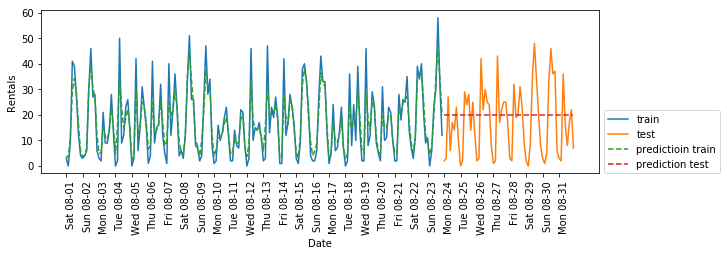

In [25]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X, y, regressor)
# テストセットに対しては定数の線が表示されてしまっている
# テストセットのPOSIX時刻特徴量の値は、訓練セットの特徴量値レンジを外れてしまっている（時系列的に後ろとしているから）
# 決定木は訓練セットのレンジの外までには外挿できない

Test set R^2: 0.6


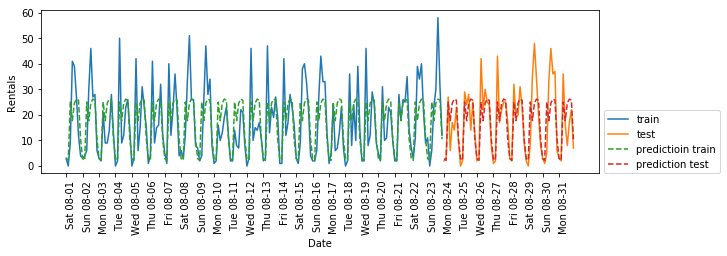

In [29]:
X_hour = np.array(citibike.index.hour.tolist()).reshape(-1, 1)
eval_on_features(X_hour, y, regressor)
# 予測は曜日に関わらず、同じパターンを描いている

Test set R^2: 0.842


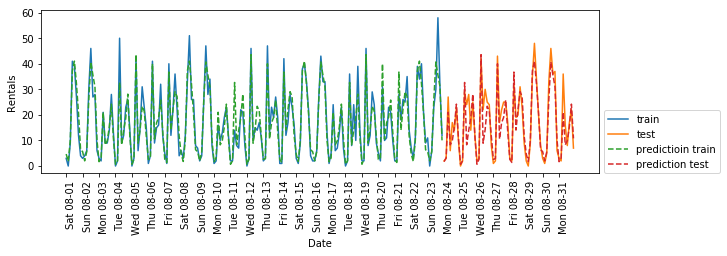

In [31]:
# 曜日情報を加えてみる
X_hour_week = np.hstack([np.array(citibike.index.dayofweek.tolist()).reshape(-1, 1), np.array(citibike.index.hour.tolist()).reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

/Users/takaaki-suzuki/.pyenv/versions/3.6.5/envs/sklearn-test/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Test set R^2: 0.132


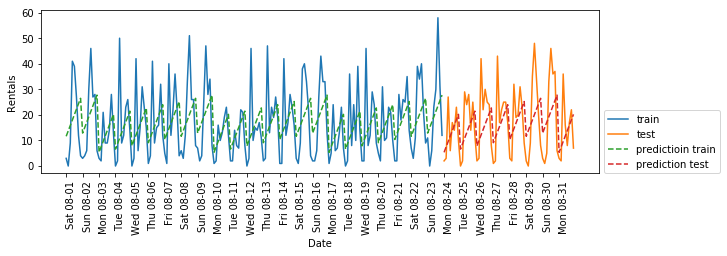

In [32]:
from sklearn.linear_model import LinearRegression
# 曜日や時刻が正数でエンコードされていて、連続値として解釈されている
# 線形モデルは時刻に対する線形関数としてしか学習ができないので、時刻が遅いほどレンタル数が大きくなると学習してしまっている
eval_on_features(X_hour_week, y, LinearRegression())

Test set R^2: 0.619


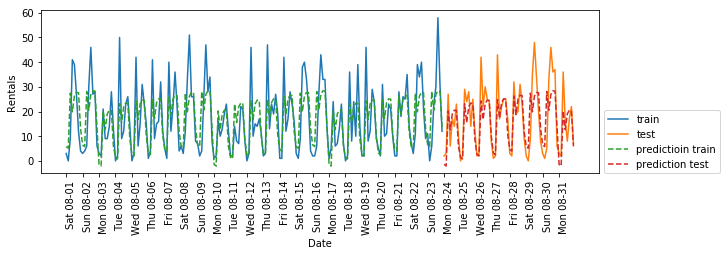

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

# 特徴量を連続値としたものよりも、はるかに良い結果が得られている
# ここでは、線形モデルは曜日と時刻に対してそれぞれ係数を学習する、つまり、時刻に対するパターンは全ての曜日に対して同じになる
eval_on_features(X_hour_week_onehot, y, Ridge())

Test set R^2: 0.845


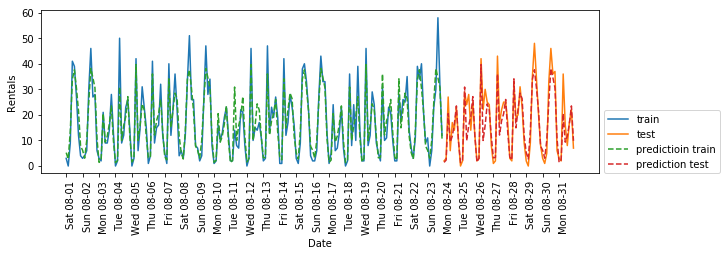

In [34]:
# ここで、交互作用特徴量を用いれば、曜日と時刻の組み合わせに対して係数を学習させることができる
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [35]:
# このモデルで学習した係数をプロットしてみる
hour = ["%02d:00" % i for  i in range(0, 24, 3)]
day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
features = day + hour

In [36]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

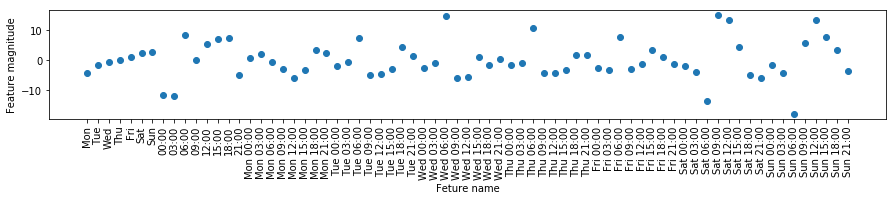

In [39]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel('Feture name')
plt.ylabel('Feature magnitude')
plt.show()
# 時刻と曜日の積を用いた線形回帰モデルの係数